Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.



# Episodic Curiosity: Plot graphs from training logs

This colab plots graphs from the logs ot the training jobs for Episodic Curiosity.

We assume training jobs are launched on Google Cloud using the script `launch_cloud_vms.py` and dump training logs on a Google Cloud bucket, but the colab could easily be adapted to other settings.

The `gsutil` command must be installed. It can be obtained from the [Google Cloud SDK](https://cloud.google.com/sdk).

In [0]:
#@title Parameters

import os

# This is the path on the Google Cloud bucket where all experiment data is 
# stored by the training jobs. This corresponds to `CLOUD_BUCKET_PATH` in
# scripts/launch_cloud_vms.py.
# E.g. 'gs://my-episodic-curiosity-bucket'.
CLOUD_LOGS_PATH = 'FILL-ME'  #@param { type: "string" }

# Path on this machine where the experimental data will be copied to,
# before being analyzed in this notebook. Large files, such as model
# checkpoints, won't be copied for space efficiency.
LOCAL_PATH = '/tmp/episodic-curiosity'  #@param { type: "string" }

# Reward file to use to draw the graphs.
REWARD_FILENAME = 'reward_test.csv'  #@param { type: "string" }

# Comma-separated list of run prefixes to plot graphs for. If empty, all runs
# will be plotted.
RUN_PREFIXES_COMMA_SEPARATED = ''  #@param { type: "string" }

RUN_PREFIXES = RUN_PREFIXES_COMMA_SEPARATED.split(',')

PATH_REGEXP = os.path.join(
    LOCAL_PATH,
    r'(?P<vm_id>.+)/(?P<method>.+)/(?P<scenario>.+)/run_number_(?P<run_number>\d+)')

In [0]:
# Sync CLOUD_LOGS_PATH into LOCAL_PATH. We exclude large files to make transfer
# much faster.
!gsutil -m rsync -r -x '.*h5.*|.*checkpoints.*|.*monitor.*|.*make_model.*|.*r_training_data.*' {CLOUD_LOGS_PATH} {LOCAL_PATH}

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import csv
import matplotlib.pyplot as plt
import os
import re
import pandas
import subprocess
import seaborn as sns

from colabtools import interactive_table

def contains_one_substr(substrs, name):
  if not substrs:
    return True
  for sub in substrs:
    if sub in name:
      return True
  return False

def read_experiment_logs_into_pandas_df():
  """Reads the training logs from LOCAL_PATH and returns a Pandas DataFrame."""
  df_dict = collections.defaultdict(list)
  for dirname, subdirs, filenames in os.walk(LOCAL_PATH):
    if REWARD_FILENAME not in filenames:
      continue
    if not contains_one_substr(RUN_PREFIXES, dirname):
      continue
    match = re.search(PATH_REGEXP, dirname)
    if not match:
      continue
    with open(os.path.join(dirname, REWARD_FILENAME)) as reward_file:
      reader = csv.DictReader(reward_file)
      try:
        for row in reader:
          df_dict['step'].append(int(row['step']))
          df_dict['timestamp_s'].append(int(row['timestamp_s']))
          metric_name = os.path.splitext(REWARD_FILENAME)[0]
          df_dict[metric_name].append(float(row[metric_name]))
          df_dict['vm_id'].append(match.group('vm_id'))
          df_dict['method'].append(match.group('method'))
          df_dict['scenario'].append(match.group('scenario'))
          df_dict['run_number'].append(match.group('run_number'))
      except csv.Error as e:
        print('WARNING:', e)

  return pandas.DataFrame.from_dict(df_dict)


def plot_experiments(experiment_df):
  """Plots one graph per scenario."""
  scenarios = sorted(list(experiment_df["scenario"].unique()))
  print('Scenarios found:', scenarios)
  fig, axs = plt.subplots(nrows=len(scenarios), squeeze=False,
                          figsize=(10, 6 * len(scenarios)))
  axs = axs.flatten()
  fig.subplots_adjust(hspace=0.3)
  for scenario, ax in zip(scenarios, axs):
    df = experiment_df.copy()
    df = df[df['scenario'] == scenario]
    sns.lineplot(x='step',
                 y=os.path.splitext(REWARD_FILENAME)[0],
                 data=df, hue='method', legend='full', ax=ax)
    ax.set_title('Scenario: {}'.format(scenario))


In [0]:
experiment_df = read_experiment_logs_into_pandas_df()
interactive_table.Create(experiment_df)

Scenarios found: ['dense1', 'noreward', 'sparse', 'verysparse']


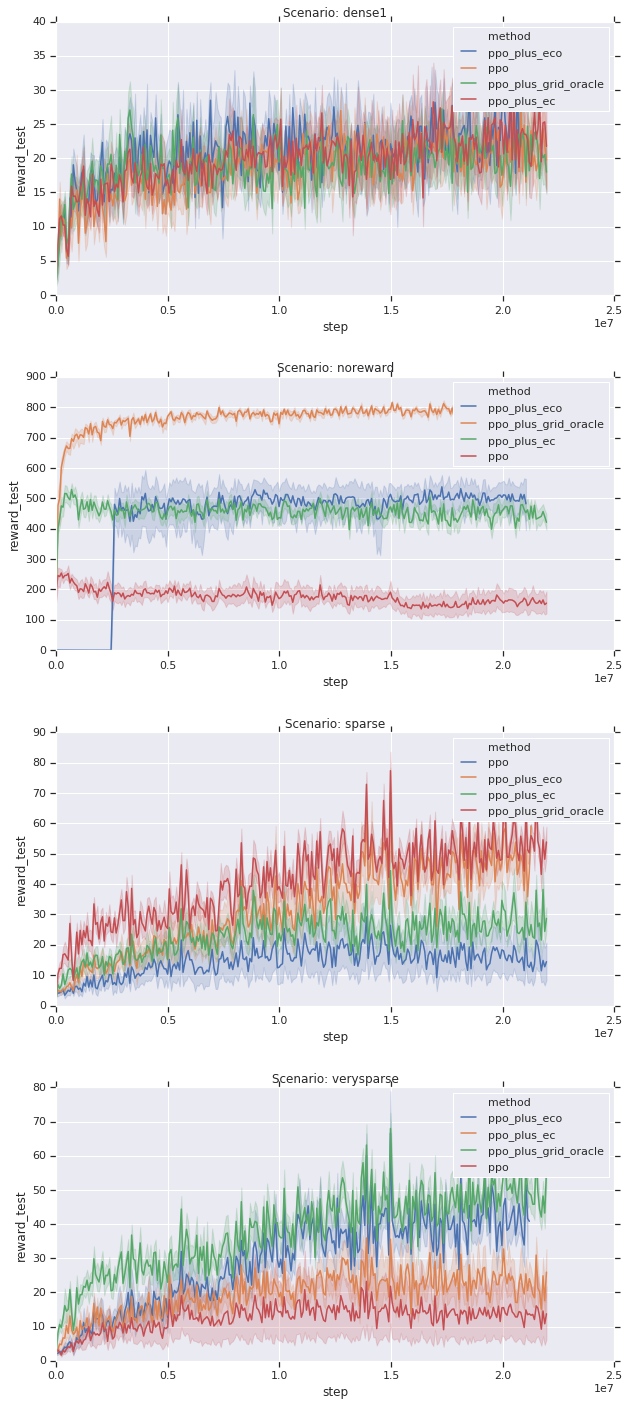

In [35]:
plot_experiments(experiment_df)